# Implementation of  Croston, ARIMA and MA models for forecasting the sales of Bestbuy

In [12]:
# Loading the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sktime.forecasting.croston import Croston
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from collections import defaultdict
import random


In [13]:
#Loading the preprocessed data
df10 = pd.read_csv(
    '/Users/sunilravilla/Documents/Best Buy/Best_buy_Data_preprocessed_dates_ordered.csv')
df10.head(5)

,encoded_sku_id,sales_date,subclass_name,class_name,ml_name,category_name,retail_price,promo_price,competitor_price,inventory,daily_units,promo_price_avbl,competitor_price_avbl,month,week,day
0,1,2017-05-28,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,89.99,89.99,Fully-Stocked,0.0,0.0,0.0,5,21,Sunday
1,1,2017-05-29,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,89.99,89.99,Fully-Stocked,0.0,0.0,0.0,5,22,Monday
2,1,2017-05-30,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,89.99,89.99,Fully-Stocked,0.0,0.0,0.0,5,22,Tuesday
3,1,2017-05-31,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,89.99,89.99,Fully-Stocked,0.0,0.0,0.0,5,22,Wednesday
4,1,2017-06-01,MISC CAMERA ACCES,DIGITAL CAMERA ACCY,ML - DI Accessories,VP - Digital Imaging,89.99,89.99,89.99,Fully-Stocked,0.0,0.0,0.0,6,22,Thursday


In [14]:
# sorting the data by encoded_sku_id and sales_date
df10 = df10.sort_values(
    by=['encoded_sku_id', 'sales_date']).reset_index(drop=True)
df10.head(2)

# Filtering the columns that are required for the analysis
df11 = df10[['encoded_sku_id', 'sales_date', 'daily_units']]
# Converting the data type of SALES_DATE to datetime
df11['sales_date'] = pd.to_datetime(df11['sales_date'])
df11.head()


/var/folders/lb/b10ttmcx6p96khnw319kfyth0000gn/T/ipykernel_92954/2532809934.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df11['sales_date'] = pd.to_datetime(df11['sales_date'])


,encoded_sku_id,sales_date,daily_units
0,1,2017-05-28,0.0
1,1,2017-05-29,0.0
2,1,2017-05-30,0.0
3,1,2017-05-31,0.0
4,1,2017-06-01,0.0


In [15]:
#loading validation data
df_val = pd.read_csv(
    '/Users/sunilravilla/Documents/Best Buy/Best_buy__Validation_Data_preprocessed.csv')
df_val.head(50)

# sorting the validation data by encoded_sku_id and sales_date
df_val = df_val.sort_values(
    by=['encoded_sku_id', 'sales_date']).reset_index(drop=True)
df_val.head(2)

# Filtering the columns that are required for the analysis
df_val_1 = df_val[['encoded_sku_id', 'sales_date', 'daily_units']]
df_val_1.head()


,encoded_sku_id,sales_date,daily_units
0,1,2022-08-01,0.0
1,1,2022-08-02,1.0
2,1,2022-08-03,0.0
3,1,2022-08-04,0.0
4,1,2022-08-05,1.0


In [16]:
#Function CROSTON (TSB) to forecast the demand
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    # print(d)
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
# Initialization
    # print(d[:cols])
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [17]:
#Implementing Croston's method for all the SKUs in validation data
import random
random.seed(143)
sku_list = df_val_1['encoded_sku_id'].unique()
targetlist = list(sku_list)
rmse_dict = defaultdict(float)

#for the  SKUs in targetlist, we will forecast the demand for the next 7 days using Croston's method
for i in targetlist:
    #Train and test split
    train = df11[df11['encoded_sku_id'] == i].reset_index(drop=True)
    test = df_val_1[df_val_1['encoded_sku_id'] == i].reset_index(drop=True)
    
    #Forecasting using Croston's method
    df1 = Croston_TSB(train['daily_units'],extra_periods=7,alpha=0.4,beta=0.4)
    #Plotting the actual and predicted values
    plt.plot(train['daily_units'], label='Train')
    plt.plot(test['daily_units'], label='Test')
    plt.plot(df1['Forecast'][-7:], label='Predicted')
    #calculating the RMSE
    rmse = np.sqrt(mean_squared_error(
        test['daily_units'], df1['Forecast'][-7:]))
    #zooming in to see the actual and predicted values
    plt.xlim(1850, 1900)
 
    #printing the RMSE on the plot
    plt.text(1850, 0.5, 'RMSE: %.2f' % (rmse), fontsize=12)

    plt.legend()
    plt.title('Croston Forecasting for SKU {}'.format(i))
    #saving all plots as images in a folder
    plt.savefig('Croston_{}.png'.format(i))
    plt.close()

    #Store RMSE values in a dictionary with the key as the SKU
    rmse_dict[i] = rmse

#Converting the dictionary to a dataframe
Croston_rmse_df = pd.DataFrame.from_dict(
    rmse_dict, orient='index', columns=['rmse'])
#create a column with the SKU
Croston_rmse_df['sku_id'] = Croston_rmse_df.index
Croston_rmse_df = Croston_rmse_df[['sku_id', 'rmse']].reset_index(drop=True)



#Calculation of  mean RMSE
Croston_mean_RMSE = Croston_rmse_df['rmse'].mean()
print('mean RMSE is', Croston_mean_RMSE)



mean RMSE is 2.1208870809668388


In [18]:
# Implementing ARIMA for all the SKUs in validation data

random.seed(143)
sku_list = df_val_1['encoded_sku_id'].unique()
targetlist = list(sku_list)
rmse_dict = defaultdict(float)

#for the  SKUs in targetlist, we will forecast the demand for the next 7 days using ARIMA
for i in targetlist:
    # Train and test split
    train = df11[df11['encoded_sku_id'] == i].reset_index(drop=True)
    test = df_val_1[df_val_1['encoded_sku_id'] == i].reset_index(drop=True)

    #Forecasting demand for next 7 days using ARIMA
    model = ARIMA(train['daily_units'], order=(1, 1, 1))
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(train), end=len(
        train)+len(test)-1, typ='levels')

    #Plotting the actual and predicted values
    plt.plot(train['daily_units'], label='Train')
    plt.plot(test['daily_units'], label='Test')
    plt.plot(yhat, label='Predicted')
    #calculating the RMSE
    rmse = np.sqrt(mean_squared_error(
        test['daily_units'], yhat))
    #zooming in to see the actual and predicted values
    plt.xlim(1850, 1900)
    #printing the RMSE on the plot
    plt.text(1850, 0.5, 'RMSE: %.2f' % (rmse), fontsize=12)

    plt.legend()
    plt.title('ARIMA Forecasting for SKU {}'.format(i))
  
    #saving all plots as images in a folder
    plt.savefig('ARIMA_{}.png'.format(i))
    plt.close()

    #Store RMSE values in a dictionary with the key as the SKU
    rmse_dict[i] = rmse

#Converting the dictionary to a dataframe
ARIMA_rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['rmse'])
#create a column with the SKU
ARIMA_rmse_df['sku_id'] = ARIMA_rmse_df.index
ARIMA_rmse_df = ARIMA_rmse_df[['sku_id', 'rmse']].reset_index(drop=True)


#Calculation of  mean RMSE
# print(ARIMA_rmse_df)
ARIMA_mean_RMSE = ARIMA_rmse_df['rmse'].mean()
print('ARIMA mean RMSE is', ARIMA_mean_RMSE)


/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

ARIMA mean RMSE is 2.319377890787834


In [19]:

# Implementing Moving Average (MA) for all the SKUs in validation data

sku_list = df_val_1['encoded_sku_id'].unique()
targetlist = list(sku_list)
rmse_dict = defaultdict(float)

#for the  SKUs in targetlist, we will forecast the demand for the next 7 days using MA
for i in targetlist:
    #Train and test split
    train = df11[df11['encoded_sku_id'] == i].reset_index(drop=True)
    test = df_val_1[df_val_1['encoded_sku_id'] == i].reset_index(drop=True)

    #Forecasting demand for next 7 days using moving average
    model = ARIMA(train['daily_units'], order=(0, 0, 1))
    model_fit = model.fit()
    # make predictions
    yhat = model_fit.predict(start=len(train), end=len(
        train)+len(test)-1, typ='levels')

    #Plotting the actual and predicted values
    plt.plot(train['daily_units'], label='Train')
    plt.plot(test['daily_units'], label='Test')
    plt.plot(yhat, label='Predicted')
    #calculating the RMSE
    rmse = np.sqrt(mean_squared_error(
        test['daily_units'], yhat))
    #zooming in to see the actual and predicted values
    plt.xlim(1850, 1900)

    #printing the RMSE on the plot
    plt.text(1850, 0.5, 'RMSE: %.2f' % (rmse), fontsize=12)

    plt.legend()
    plt.title('MA Forecasting for SKU {}'.format(i))
   
    #saving all plots as images in a folder
    plt.savefig('MA_{}.png'.format(i))
    plt.close()

    #Store RMSE values in a dictionary with the key as the SKU
    rmse_dict[i] = rmse

#Converting the dictionary to a dataframe
MA_rmse_df = pd.DataFrame.from_dict(
    rmse_dict, orient='index', columns=['rmse'])
#create a column with the SKU
MA_rmse_df['sku_id'] = MA_rmse_df.index
MA_rmse_df = MA_rmse_df[['sku_id', 'rmse']].reset_index(drop=True)


#Calculation of  mean RMSE
MA_mean_RMSE = MA_rmse_df['rmse'].mean()
print('MA mean RMSE is', MA_mean_RMSE)


/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/sunilravilla/tensorflow-test/env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA mean RMSE is 8.398554104789342


# Implementation of  Croston, ARIMA and MA models for forecasting the sales of Bestbuy

In [20]:
#merge croston,ARIMA, MA and triple exp RMSE dataframes
RMSE_df = pd.merge(Croston_rmse_df, ARIMA_rmse_df, on='sku_id')
RMSE_df = pd.merge(RMSE_df, MA_rmse_df, on='sku_id')
# RMSE_df = pd.merge(RMSE_df, Triple_exp_df, on='SKU_id')
RMSE_df.columns = ['sku_id', 'Croston_RMSE',
                   'ARIMA_RMSE', 'MA_RMSE']
RMSE_df

#write the RMSE dataframe to a csv file
RMSE_df.to_csv('RMSE_df_with_val_dates_ordered.csv', index=False)


In [21]:
#load the RMSE dataframe
RMSE_df = pd.read_csv('RMSE_df_with_val_dates_ordered.csv')
RMSE_df

,sku_id,Croston_RMSE,ARIMA_RMSE,MA_RMSE
0,1,0.883043,0.994037,1.588456
1,2,1.661757,1.779472,9.957004
2,3,0.722066,0.744528,1.685103
3,5,1.583664,1.577775,2.752414
4,6,8.371374,6.665554,6.683811
...,...,...,...,...
534,571,0.997725,0.993411,3.783380
535,572,1.148581,1.127914,2.223846
536,573,1.018838,0.888598,4.807407
537,574,0.570660,0.801405,20.707446


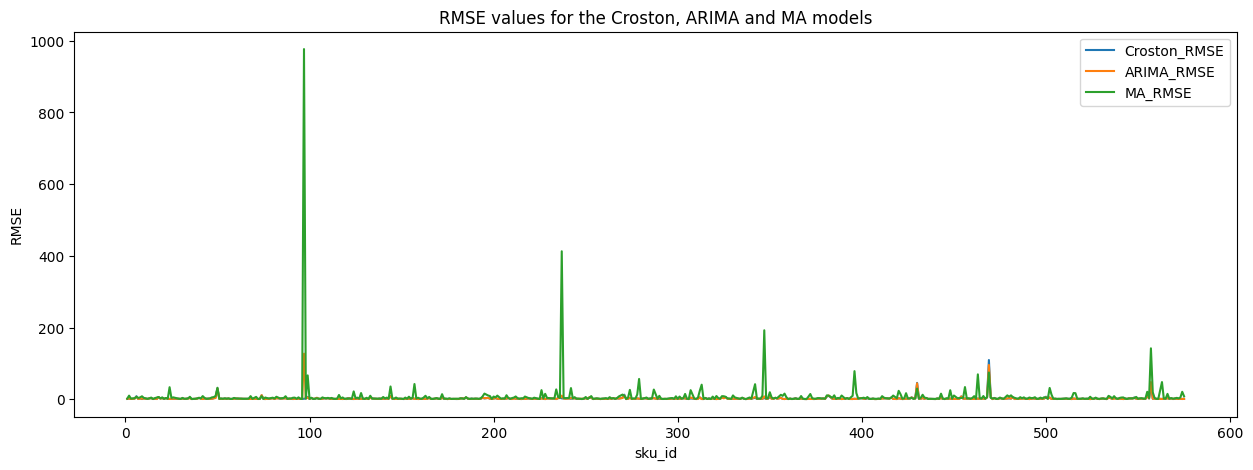

In [22]:
#plot the RMSE values for the 3 models
RMSE_df.plot(x='sku_id', y=['Croston_RMSE', 'ARIMA_RMSE', 'MA_RMSE'], figsize=(15, 5))
plt.title('RMSE values for the Croston, ARIMA and MA models')
plt.xlabel('sku_id')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# THE END!!!